In [2]:
from sklearn.model_selection import train_test_split
import shutil
import os 

IMAGES_PATH = "/kaggle/input/autograde-data/train/Trainning_SET/Images"
LABELS_PATH = "/kaggle/input/autograde-data/train/Trainning_SET/Labels"

labels = os.listdir(LABELS_PATH)

train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("valid/images")
os.makedirs("valid/labels")

def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.jpg"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")

move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

print("Train Test Split Done!")

train: 4420; valid: 624; test: 156
Train Test Split Done!


# Find Square Contour

In [42]:
import numpy as np
import cv2
from cv2.typing import MatLike
import matplotlib.pyplot as plt


def between(num, num1, num2):
    if num1 >= num2:
        return False 
    return num >= num1 and num <= num2 

def is_square(contour: MatLike):
    peri = cv2.arcLength(contour, True)
    poly = cv2.approxPolyDP(contour, peri*0.07, True)
    area = cv2.contourArea(contour)
    (_,_,w,h) = cv2.boundingRect(contour)
    return len(poly) == 4 and between(w, 25, 35) and between(h, 25, 35)

def findSquareContours(img_path):
    phieu_tno = cv2.imread(img_path)
    phieu_tno = cv2.cvtColor(phieu_tno, cv2.COLOR_BGR2RGB)
    phieu_tno_gray = cv2.cvtColor(phieu_tno, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(phieu_tno_gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1],[-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
    thresh = cv2.threshold(sharpen, 100, 255, cv2.THRESH_BINARY_INV)[1] #convert to binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)) 
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2) #decrease noise
    cnts, _ = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
    square = list(filter(is_square, cnts))
    square = [x for x in square if check_is_filled(thresh, x, 0.85)] #filter square that was colored more than 85percent
    
    return square 

def check_is_filled(src, contour: MatLike, desired_ratio):
    # check inside part of the contour, if colored part is considerable, called them is filled
    (x, y, w, h) = cv2.boundingRect(contour)
    area = src[y: y+h, x:x+w]
    filled_ratio = cv2.countNonZero(area)*1.0 / (w*h)
    return filled_ratio > desired_ratio

In [ ]:
right_number = 27
wrong_count = 0
i = 0
for root, _, filenames in os.walk('/kaggle/working/train/images'):
    for img in filenames:
        number_detected = len(findSquareContours(os.path.join(root, img)))
        i += 1
        if number_detected != right_number:
            print(f'{img}: {findSquareContours(os.path.join(root,img))} square contours found')
            wrong_count+=1
        print(f'\r{wrong_count}/{i}',end="")
print(f'\nWrong images: {wrong_count}')

27

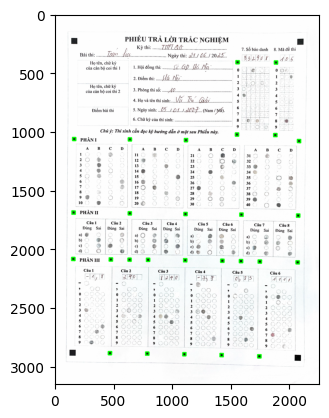

In [10]:
def drawSquareContours(img_path):
    phieu_tno = cv2.imread(img_path)
    square = findSquareContours(img_path)
    cv2.drawContours(phieu_tno, square, -1, (0,255,0), 10)
    plt.imshow(phieu_tno)
    return len(square)
drawSquareContours("/kaggle/working/test/images/IMG_1581_iter_103.jpg")

# Fix Perspective

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=1ba8575273217bcc6ff51b942f27b93790c8445e5796032709cb6db91f426342
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


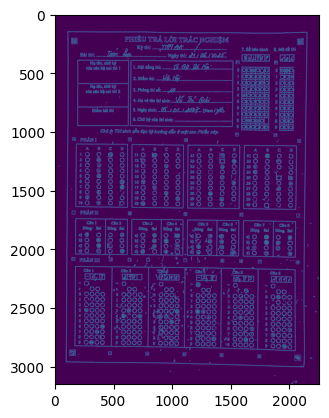

In [2]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from cv2.typing import MatLike


img_path = "/kaggle/working/test/images/IMG_1581_iter_103.jpg"

image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 5, 20) # decrease the range to save more details, increate to lost more

plt.imshow(edged)

4

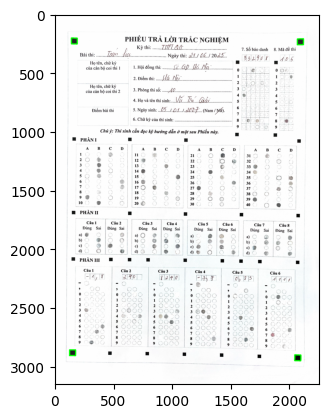

In [27]:
def drawCornerContours(img_path):
    phieu_tno = cv2.imread(img_path)
    square = findCornerContours(img_path)
    cv2.drawContours(phieu_tno, square, -1, (0,255,0), 10)
    plt.imshow(phieu_tno)
    return len(square)
drawCornerContours("/kaggle/working/test/images/IMG_1581_iter_103.jpg")

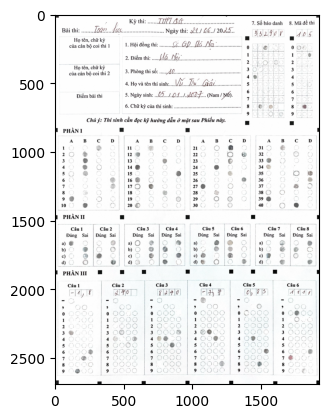

In [36]:
##########################################BASED ON CENTROID OF CORNER SQUARE############################



def check_is_filled(src, contour: MatLike, desired_ratio):
    # check inside part of the contour, if colored part is considerable, called them is filled
    (x, y, w, h) = cv2.boundingRect(contour)
    area = src[y: y+h, x:x+w]
    filled_ratio = cv2.countNonZero(area)*1.0 / (w*h)
    return filled_ratio > desired_ratio

def between(num, num1, num2):
    if num1 >= num2:
        return False 
    return num >= num1 and num <= num2 

def is_big_square(contour: MatLike):
    # kiểm tra tứ giác, chiều dài, rộng trong khoảng 25 đến 35
    peri = cv2.arcLength(contour,True)
    poly = cv2.approxPolyDP(contour,peri*0.07,True)
    area = cv2.contourArea(contour)
    (_,_,w,h) = cv2.boundingRect(contour)
    return len(poly) == 4 and between(w,50,70) and between(h,50,70)

def findCornerContours(img_path):
    phieu_tno = cv2.imread(img_path)
    phieu_tno = cv2.cvtColor(phieu_tno, cv2.COLOR_BGR2RGB)
    phieu_tno_gray = cv2.cvtColor(phieu_tno, cv2.COLOR_RGB2GRAY) # chuyển về grayscale
    blur = cv2.medianBlur(phieu_tno_gray,5) # blur hình một chút để tăng độ chính xác
    sharpen_kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) 
    sharpen = cv2.filter2D(blur,-1,sharpen_kernel) # mài các góc cạnh
    thresh = cv2.threshold(sharpen,100,255,cv2.THRESH_BINARY_INV)[1] # đưa về ảnh nhị phân
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2) # giảm các "noise", hay phần bị nhiễu
    cnts, _ = cv2.findContours(close, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # tìm contour
    square = list(filter(is_big_square,cnts))
    square = [x for x in square if check_is_filled(thresh,x,0.85)]

    return square 

def get_centroid(contour):
    M = cv2.moments(contour)
    if M['m00'] == 0:
        return None
    cX = int(M['m10']/M['m00'])
    cY = int(M['m01']/M['m00'])
    return (cX, cY)

def findCornerContourCentroid(img_path):
    square = findCornerContours(img_path)

    centroids = [get_centroid(contour) for contour in square]
    centroids = [c for c in centroids if c is not None]

    return centroids


def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform1(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


square_corner = findCornerContours(img_path)
corner_centroids = findCornerContourCentroid(img_path)

corner_centroids = np.array(corner_centroids)

rect = order_points(corner_centroids)

warped = four_point_transform1(image, corner_centroids)

plt.imshow(warped)

# from PIL import Image
# output = Image.fromarray(warped)
# output.save("perspective_transform.jpg")


In [14]:
warped.shape

(2691, 1925, 3)

In [3]:
##########################################BASED ON CORNER OF CORNER SQUARE###################



def check_is_filled(src, contour: MatLike, desired_ratio):
    # check inside part of the contour, if colored part is considerable, called them is filled
    (x, y, w, h) = cv2.boundingRect(contour)
    area = src[y: y+h, x:x+w]
    filled_ratio = cv2.countNonZero(area)*1.0 / (w*h)
    return filled_ratio > desired_ratio

def between(num, num1, num2):
    if num1 >= num2:
        return False 
    return num >= num1 and num <= num2 

def is_big_square(contour: MatLike):
    # kiểm tra tứ giác, chiều dài, rộng trong khoảng 25 đến 35
    peri = cv2.arcLength(contour,True)
    poly = cv2.approxPolyDP(contour,peri*0.07,True)
    area = cv2.contourArea(contour)
    (_,_,w,h) = cv2.boundingRect(contour)
    return len(poly) == 4 and between(w,50,70) and between(h,50,70)

def findCornerContours(img_path):
    phieu_tno = cv2.imread(img_path)
    phieu_tno = cv2.cvtColor(phieu_tno, cv2.COLOR_BGR2RGB)
    phieu_tno_gray = cv2.cvtColor(phieu_tno, cv2.COLOR_RGB2GRAY) # chuyển về grayscale
    blur = cv2.medianBlur(phieu_tno_gray,5) # blur hình một chút để tăng độ chính xác
    sharpen_kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) 
    sharpen = cv2.filter2D(blur,-1,sharpen_kernel) # mài các góc cạnh
    thresh = cv2.threshold(sharpen,100,255,cv2.THRESH_BINARY_INV)[1] # đưa về ảnh nhị phân
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2) # giảm các "noise", hay phần bị nhiễu
    cnts, _ = cv2.findContours(close, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # tìm contour
    square = list(filter(is_big_square,cnts))
    square = [x for x in square if check_is_filled(thresh,x,0.85)]

    return square 


def get_topleft_points(img_path):

    square = findCornerContours(img_path)
    lst_coor = []
    dic = dict()
    avg = 0
    for cnt in square:
        (x, y, w, h) = cv2.boundingRect(cnt)
        lst_coor.append((x,y))
        dic[(x,y)] = (w,h)

    return lst_coor, dic


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "int32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return_rect = [tuple(re) for re in list(rect)]
    
    return return_rect


def get_corner_points(img_path):
    lst_coor, dic = get_topleft_points(img_path)
    rect = order_points(np.array(lst_coor))

    return_rect = np.zeros((4, 2), dtype = "float32") 
    
    top_left = rect[0]
    top_right = (rect[1][0] + dic[rect[1]][0], rect[1][1])
    bottom_right = (rect[2][0] + dic[rect[2]][0], rect[2][1] + dic[rect[2]][1])
    bottom_left = (rect[3][0], rect[3][1] + dic[rect[3]][1])

    return_rect[0] = top_left
    return_rect[1] = top_right
    return_rect[2] = bottom_right
    return_rect[3] = bottom_left
    return return_rect

def four_point_transform2(image_path):
	# obtain a consistent order of the points and unpack them
	# individually
    image = cv2.imread(img_path)
    
    rect = get_corner_points(img_path)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped



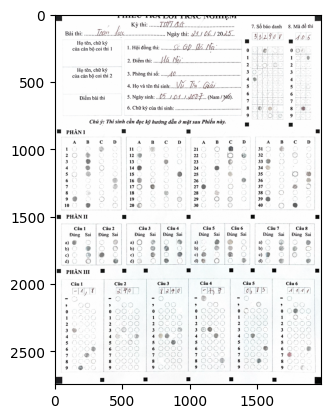

In [44]:
image_path = '/kaggle/input/autograde-data/train/Trainning_SET/Images/IMG_1581_iter_103.jpg'
warped = four_point_transform2(image_path)
plt.imshow(warped)

# Segmentation


In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=27b052694e4ed6958822431f9d8cd92553717d6207bdad9820f090db62425003
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [10]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from cv2.typing import MatLike

In [5]:
def is_square(contour: MatLike):
    peri = cv2.arcLength(contour, True)
    poly = cv2.approxPolyDP(contour, peri*0.07, True)
    area = cv2.contourArea(contour)
    (_,_,w,h) = cv2.boundingRect(contour)
    return len(poly) == 4 and between(w, 25, 35) and between(h, 25, 35)

def findSquareContours(image):
    phieu_tno = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    phieu_tno_gray = cv2.cvtColor(phieu_tno, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(phieu_tno_gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1],[-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
    thresh = cv2.threshold(sharpen, 100, 255, cv2.THRESH_BINARY_INV)[1] #convert to binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)) 
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2) #decrease noise
    cnts, _ = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
    square = list(filter(is_square, cnts))
    square = [x for x in square if check_is_filled(thresh, x, 0.85)] #filter square that was colored more than 85percent
    
    return square 

In [75]:
from PIL import Image
output = Image.fromarray(cropped_images[1])
output.save("segment_part1.jpg")

27

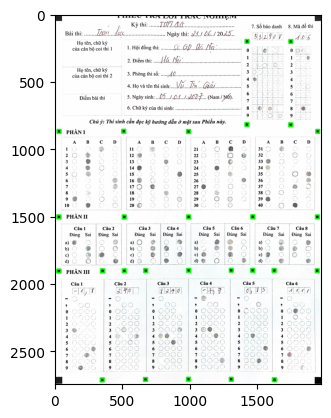

In [76]:
def drawSquareContours(image):
    square = findSquareContours(image)
    image_copy = image.copy()
    cv2.drawContours(image_copy, square, -1, (0,255,0), 10)
    plt.imshow(image_copy)
    return len(square)
drawSquareContours(warped)

In [8]:
#def get_centroid(contour):
#    M = cv2.moments(contour)
#    if M['m00'] == 0:
#        return None
#    cX = int(M['m10']/M['m00'])
#    cY = int(M['m01']/M['m00'])
#    return (cX, cY)

def get_centroid(contour):
    (x, y, w, h) = cv2.boundingRect(contour)

    cx = x + w//2
    cy = y + h//2 

    return (cx, cy)

def findSquareContourCentroid(image):
    square = findSquareContours(image)

    centroids = [get_centroid(contour) for contour in square]
    centroids = [c for c in centroids if c is not None]

    return centroids

In [9]:
centroids = findSquareContourCentroid(warped)
centroids = list(reversed(centroids))

In [10]:
centroids

[(1421, 202),
 (1745, 203),
 (1421, 819),
 (1744, 821),
 (509, 869),
 (30, 870),
 (988, 871),
 (1944, 870),
 (1463, 1503),
 (988, 1504),
 (28, 1505),
 (512, 1505),
 (1942, 1505),
 (989, 1901),
 (1304, 1900),
 (1463, 1901),
 (1622, 1901),
 (671, 1903),
 (513, 1904),
 (1941, 1903),
 (352, 1905),
 (28, 1906),
 (987, 2708),
 (1304, 2709),
 (670, 2710),
 (1624, 2712),
 (349, 2713)]

In [47]:
def sort_points_grid(pts, row_threshold=10):
    """
    Sort a set of points from left-to-right, top-to-bottom.
    
    Args:
        pts (array-like): List or numpy array of points with shape (N, 2).
        row_threshold (int): Maximum difference in y-coordinates to group points into rows.
    
    Returns:
        sorted_points (list): Points sorted left-to-right, top-to-bottom.
    """
    # Convert points to numpy array if not already
    pts = np.array(pts)
    
    # Sort points by y-coordinate (top-to-bottom)
    pts = pts[pts[:, 1].argsort()]
    
    # Initialize list for grouped rows
    rows = []
    current_row = [pts[0]]

    # Group points into rows based on the row_threshold
    for i in range(1, len(pts)):
        if abs(pts[i, 1] - current_row[-1][1]) < row_threshold:
            current_row.append(pts[i])
        else:
            # Sort current row by x-coordinate (left-to-right)
            current_row = sorted(current_row, key=lambda pt: pt[0])
            rows.append(current_row)  # Add the sorted row to rows
            current_row = [pts[i]]  # Start a new row
    
    # Add the last row
    if current_row:
        current_row = sorted(current_row, key=lambda pt: pt[0])
        rows.append(current_row)
    
    # Combine all rows into a single list
    sorted_points = [tuple(pt) for row in rows for pt in row]
    
    return sorted_points


sorted_points = sort_points_grid(centroids, row_threshold=10)
print("Sorted Points:", sorted_points)

Sorted Points: [(1421, 202), (1745, 203), (1421, 819), (1744, 821), (30, 870), (509, 869), (988, 871), (1944, 870), (28, 1505), (512, 1505), (988, 1504), (1463, 1503), (1942, 1505), (28, 1906), (352, 1905), (513, 1904), (671, 1903), (989, 1901), (1304, 1900), (1463, 1901), (1622, 1901), (1941, 1903), (349, 2713), (670, 2710), (987, 2708), (1304, 2709), (1624, 2712)]


In [66]:
import cv2
import numpy as np

def segmentation_6_parts(warped, target_size=(640, 640)):

    centroids = findSquareContourCentroid(warped)
    sorted_points = sort_points_grid(centroids, row_threshold=15)
    image = warped.copy()
    # Provided pivot points (yellow points) 
    pivot1 = sorted_points[6]  
    pivot2 = sorted_points[17]  
    
    # Calculate the mid-point of the two pivot points
    mid_x = pivot1[0]
    
    # Get image dimensions
    #width, height, _ = image.shape
    height, width, _ = image.shape
    
    # Define the boundaries for the six segments
    segments = [
        (0, pivot1[1], 0, mid_x),              # Top-left
        (0, pivot1[1], mid_x, width),          # Top-right
        (pivot1[1], pivot2[1], 0, mid_x),      # Middle-left
        (pivot1[1], pivot2[1], mid_x, width),  # Middle-right
        (pivot2[1], height, 0, mid_x),         # Bottom-left
        (pivot2[1], height, mid_x, width)      # Bottom-right
    ]
    cropped_images = []
    for idx, (y1, y2, x1, x2) in enumerate(segments):
        cropped = image[y1:y2, x1:x2]
        #resized_image = cropped
        resized_image = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
        cropped_images.append(resized_image)
    return cropped_images

# Crop the six parts
cropped_images = segmentation_6_parts(warped)

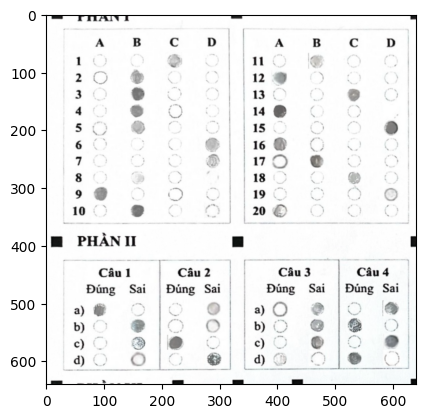

In [77]:
plt.imshow(cropped_images[2])

In [81]:
from PIL import Image
output = Image.fromarray(cropped_images[5])
output.save("segment_part5.jpg")

In [ ]:
pivot_points = (7, 18, 25)